In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

import pandas_datareader as pdr

# Markov Switching model

A times series ${x_t}$ follows a Markov switching autoregressive model if

$$x_t = \left\{\begin{matrix}
c_0 + \sum_{i=1}^p \phi_{0,i} x_{t-i} + \varepsilon_{0t} \quad \text{if } s_t=0,\\ 
c_1 + \sum_{i=1}^p \phi_{1,i} x_{t-i} + \varepsilon_{1t} \quad \text{if } s_t=1 ,
\end{matrix}\right.
$$

with $\varepsilon_{it}\sim N(0,\sigma_i^2)$.

The *state variable* $s_t$ is a *Markov chain* with transition probabilities

$$P(S_t=s_t|S_{t-1}=s_{t-1})=\begin{pmatrix}
1-\eta_0 & \eta_0 \\ 
\eta_1 & 1-\eta_1
\end{pmatrix}.$$

In words, this says that the probability of transitioning from state 0 to state 1 is $\eta_0$, and the probability of transitioning from state 1 to state 0 is $\eta_1$. These $\eta$s are additional parameters that we must estimate from the data. Note also that the rows of the transition matrix sum to one.

## GDP growth

We'll use the Real Gross Domestic Product series (in Billions of Chained 2012 Dollars, Seasonally Adjusted)

https://fred.stlouisfed.org/series/GDPC1

In [3]:
gdp = pdr.get_data_fred('GDPC1', 1947)

# set index frequency to quarterly
gdp = gdp.asfreq('QS')

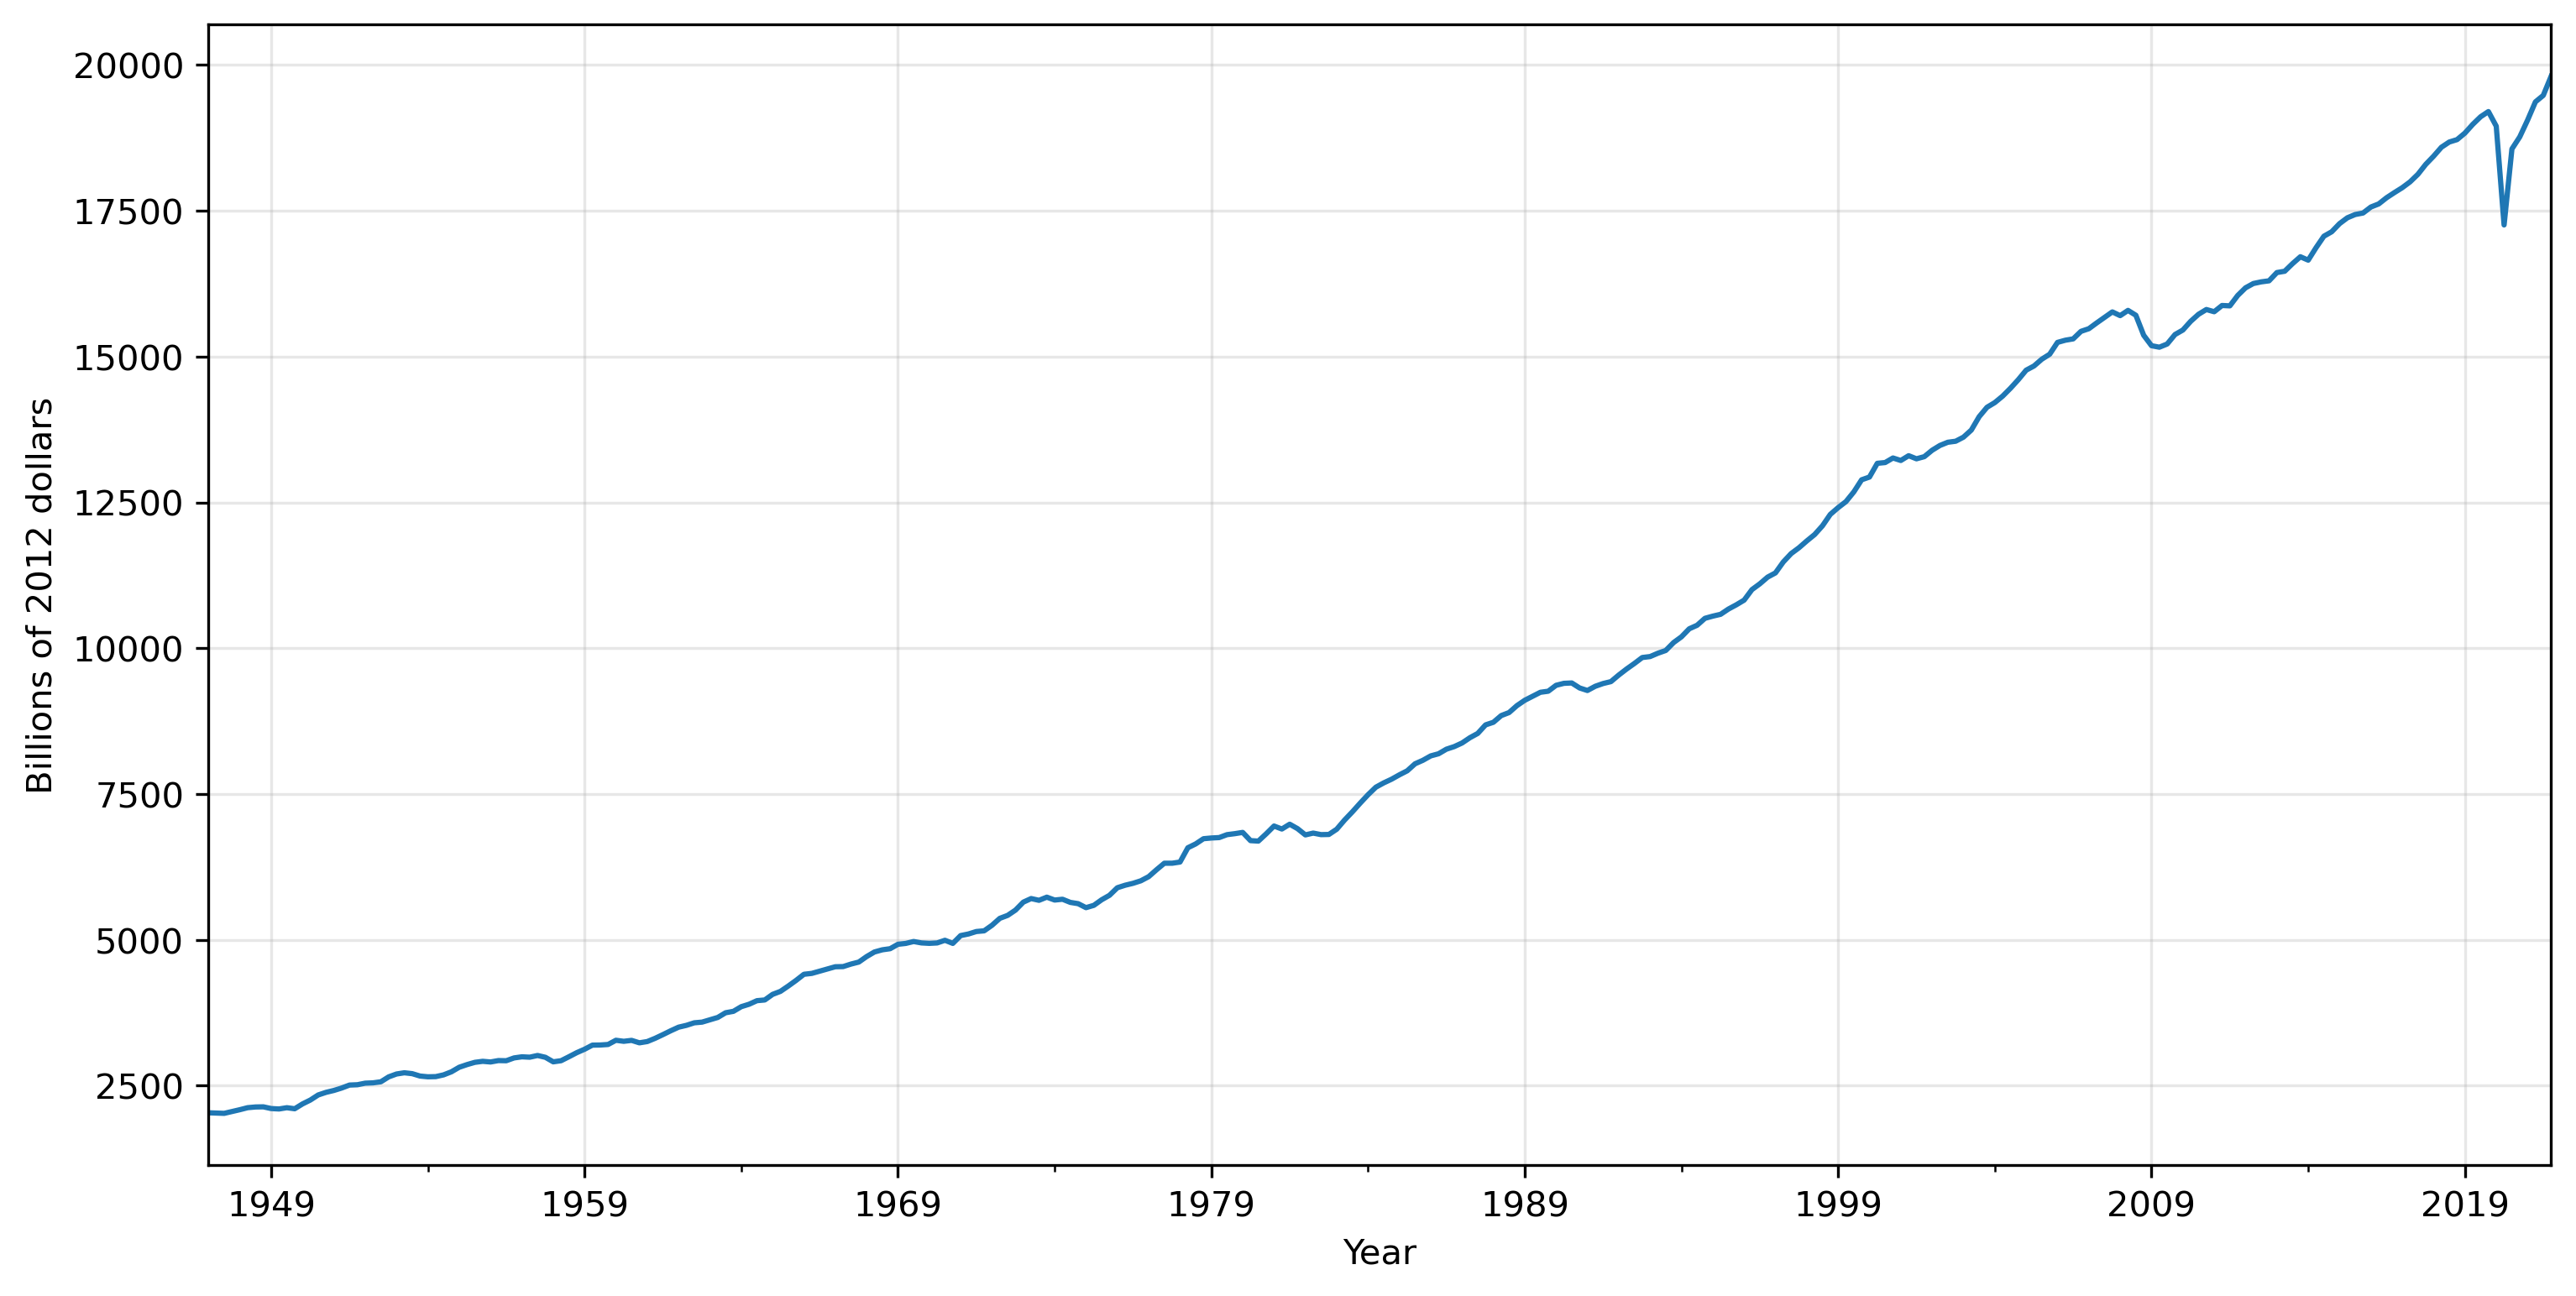

In [14]:
gdp.plot(xlabel='Year', ylabel='Billions of 2012 dollars', grid=True, legend=False);

In [15]:
gdpgr = np.log(gdp).diff().dropna()

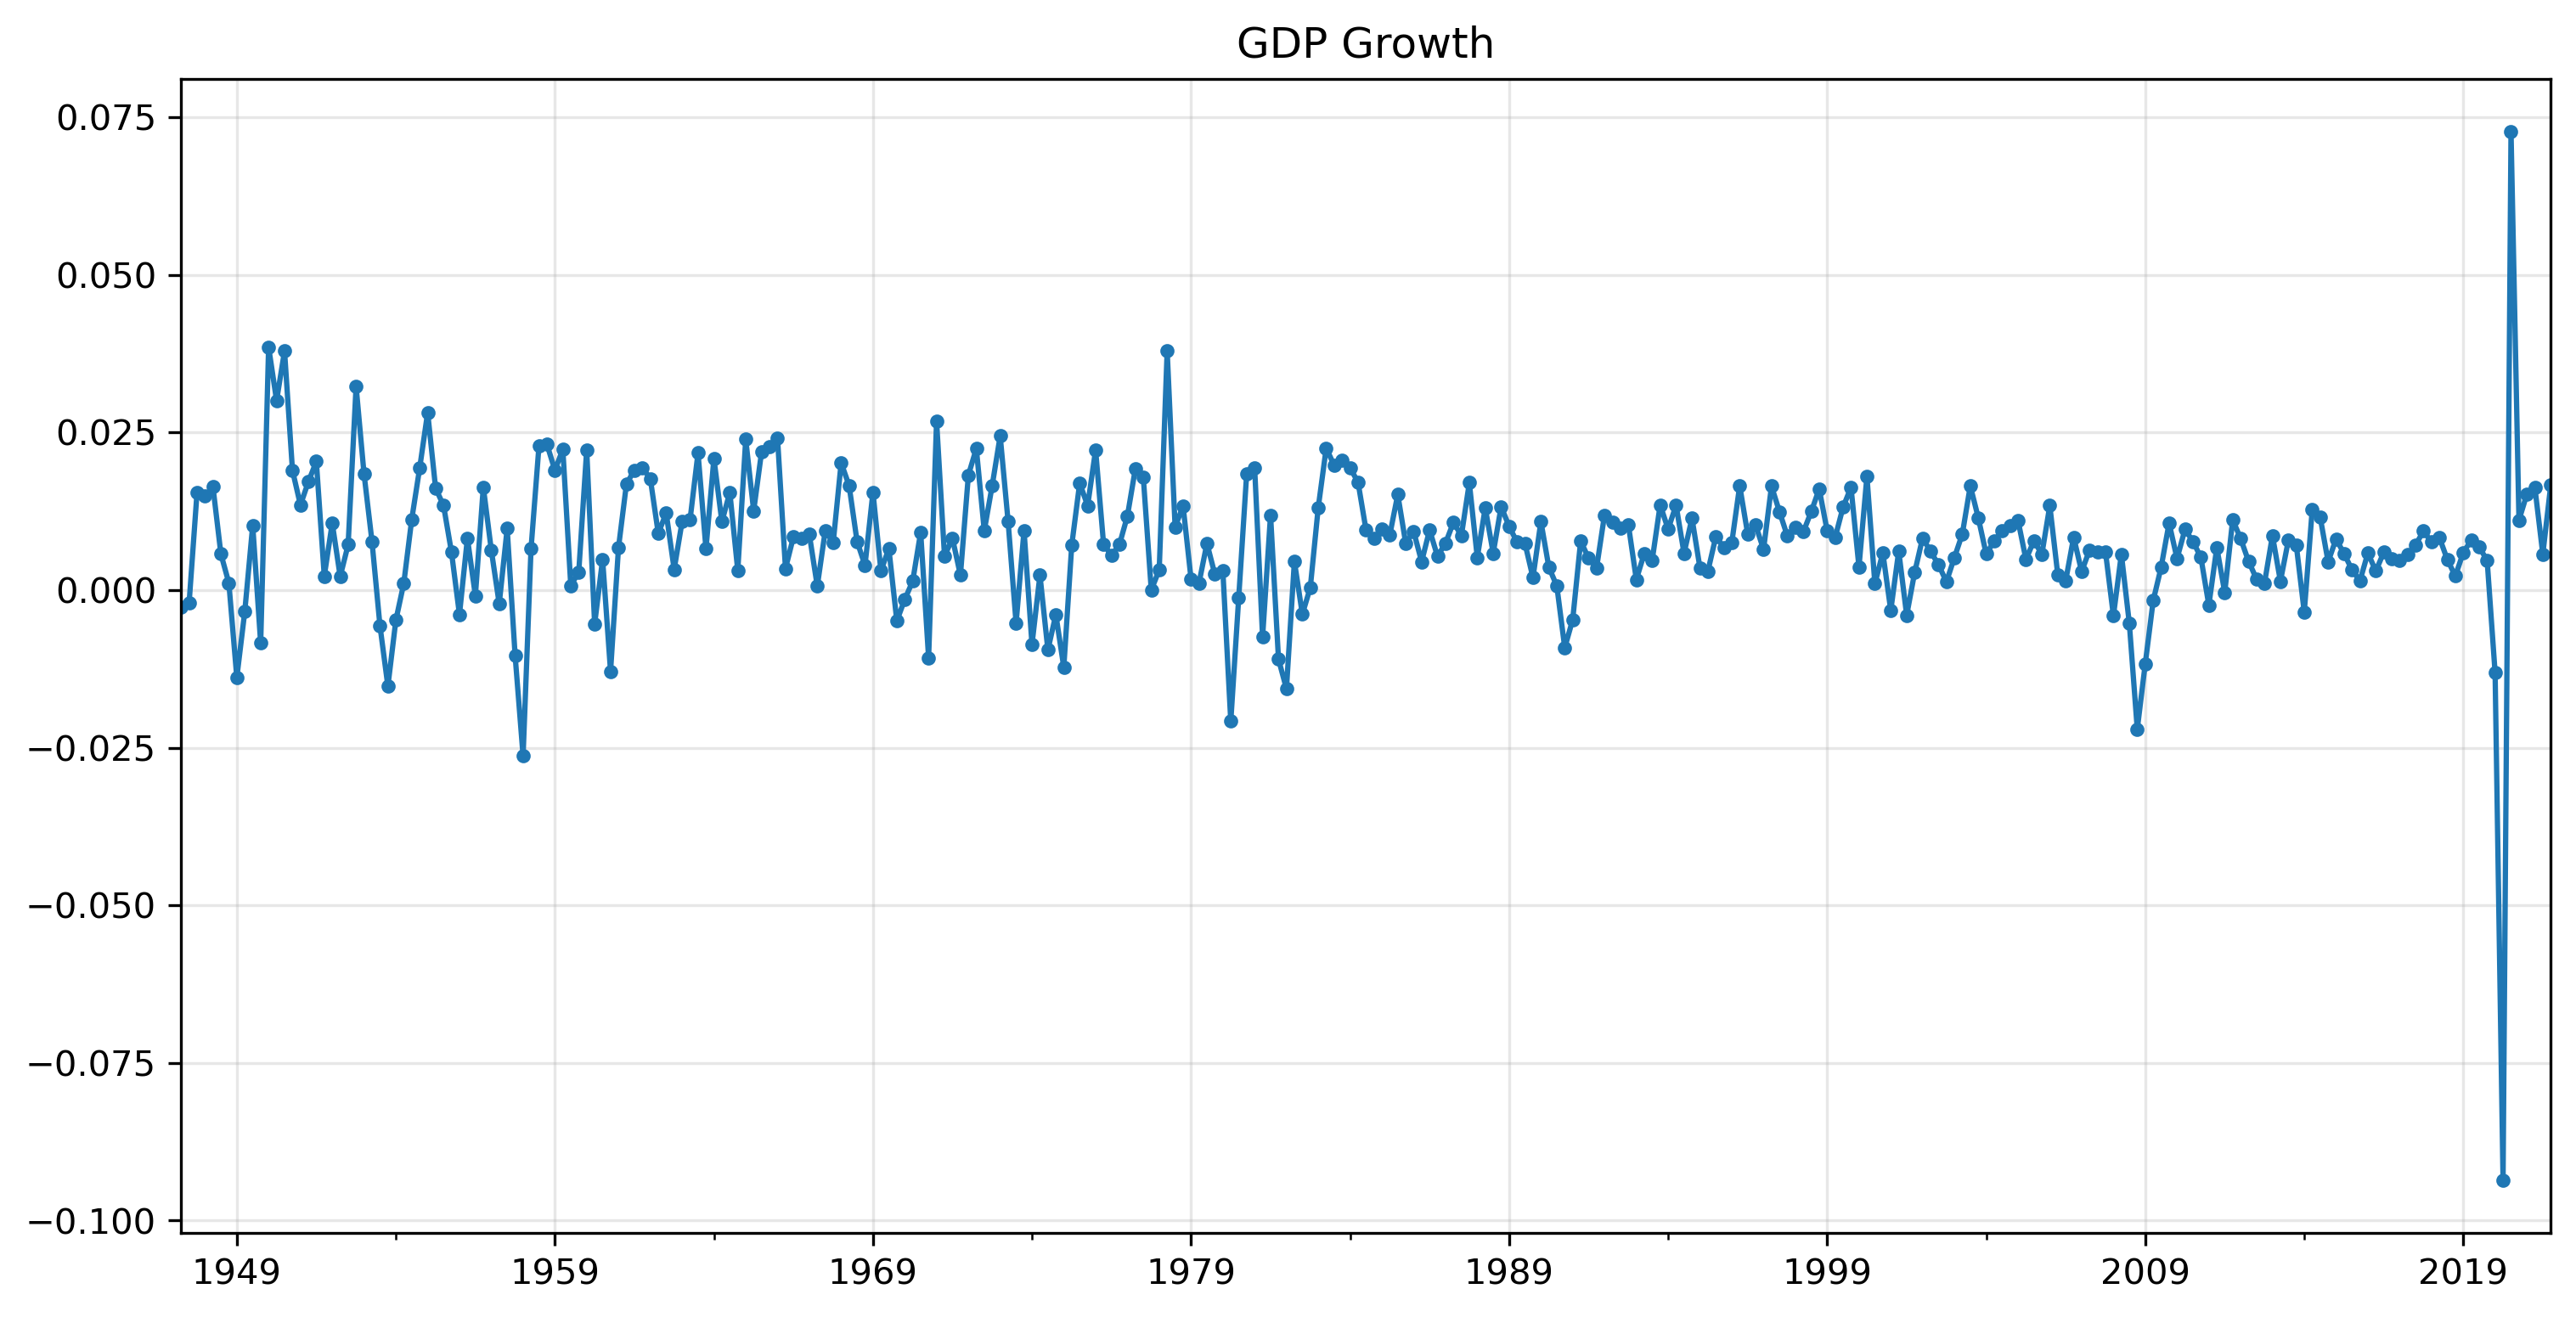

In [19]:
gdpgr.plot(marker='.', title='GDP Growth', legend=None, xlabel='', grid=True);

In [20]:
# restrict series to pre-COVID period
gdpgr = gdpgr.loc[:'2019']

In [21]:
gdpgr.describe()

,GDPC1
count,291.000000
mean,0.007714
std,0.009283
min,-0.026297
25%,0.003060
50%,0.007600
75%,0.012440
max,0.038548


In [22]:
modsel = ar_select_order(gdpgr, maxlag=12, old_names=False, ic='aic')

modsel.ar_lags

[1, 2, 3]

In [23]:
gdpgr_ar3 = AutoReg(gdpgr, 3, old_names=False).fit()
print(gdpgr_ar3.summary())

                            AutoReg Model Results                             
Dep. Variable:                  GDPC1   No. Observations:                  291
Model:                     AutoReg(3)   Log Likelihood                 963.935
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Mon, 04 Apr 2022   AIC                          -1917.870
Time:                        14:33:39   BIC                          -1899.555
Sample:                    01-01-1948   HQIC                         -1910.531
                         - 10-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.001      6.400      0.000       0.003       0.006
GDPC1.L1       0.3348      0.058      5.739      0.000       0.220       0.449
GDPC1.L2       0.1524      0.061      2.505      0.0

Start with a simple model where only the mean varies between the states.

In [24]:
gdpgr_mod = MarkovAutoregression(gdpgr, k_regimes=2, order=3, switching_ar=False)

gdpgr_res = gdpgr_mod.fit(disp=True)
print(gdpgr_res.summary())

Optimization terminated successfully.
         Current function value: -3.372851
         Iterations: 55
         Function evaluations: 72
         Gradient evaluations: 72
                         Markov Switching Model Results                         
Dep. Variable:                    GDPC1   No. Observations:                  288
Model:             MarkovAutoregression   Log Likelihood                 971.381
Date:                  Mon, 04 Apr 2022   AIC                          -1926.762
Time:                          14:33:46   BIC                          -1897.458
Sample:                      04-01-1947   HQIC                         -1915.019
                           - 10-01-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

Looking at the estimates of the transition probability, it's clear that the optimizer didn't find a good solution, which is why the standard errors on the probabilities are infinite. The likelihood function was likely not actually maximized. Let's try again with a bit more control over the optmizer.

We should get a log-likelihood of about 974.

In [25]:
gdpgr_mod2 = MarkovAutoregression(gdpgr, k_regimes=2, order=3, switching_ar=False)

In [45]:
# Note: this is advanced code. There is no need to understand it for this course.
class ParamStore():
    '''A callback class for storing parameters from optimization algorithm'''
    def __init__(self, model):
        self.model = model
        self.params = []

    def __call__(self, params):
        params = self.model.transform_params(params)
        loglik = self.model.loglike(params)
        params = pd.Series(params, index=self.model.param_names)
        params['Log-Like'] = loglik
        self.params.append(params)

    @property
    def param_history(self):
        param_history = pd.concat(self.params, axis=1).T
        param_history.index = range(1,len(param_history)+1)
        param_history.index.name = 'iteration'
        return(param_history)

param_store = ParamStore(gdpgr_mod2)

gdpgr_res2 = gdpgr_mod2.fit(disp=True,
                            em_iter=10, search_reps=20,
                            search_iter=10, callback=param_store)
print(gdpgr_res2.summary())

Optimization terminated successfully.
         Current function value: -3.382646
         Iterations: 33
         Function evaluations: 44
         Gradient evaluations: 44
                         Markov Switching Model Results                         
Dep. Variable:                    GDPC1   No. Observations:                  288
Model:             MarkovAutoregression   Log Likelihood                 974.202
Date:                  Mon, 04 Apr 2022   AIC                          -1932.404
Time:                          14:40:33   BIC                          -1903.100
Sample:                      04-01-1947   HQIC                         -1920.661
                           - 10-01-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

The DataFrame below shows how the parameter values changed through the iteration steps.

In [47]:
param_store.param_history

,p[0->0],p[1->0],const[0],const[1],sigma2,ar.L1,ar.L2,ar.L3,Log-Like
iteration,,,,,,,,,
1,0.141949,0.003634,-0.019675,0.007889,0.000065,0.319231,0.160570,-0.125746,966.953556
2,0.141949,0.003634,-0.019627,0.007980,0.000065,0.319236,0.160578,-0.125749,966.960999
3,0.141949,0.003634,-0.018581,0.007992,0.000065,0.319323,0.160745,-0.125811,967.019243
4,0.141944,0.003637,-0.018413,0.007996,0.000065,0.322607,0.166379,-0.128245,967.128967
5,0.141916,0.003652,-0.018094,0.008007,0.000065,0.331382,0.176732,-0.135636,967.318035
6,0.141802,0.003712,-0.017462,0.008036,0.000064,0.354613,0.197904,-0.153138,967.533524
7,0.141733,0.003752,-0.017519,0.008044,0.000064,0.360845,0.199685,-0.155644,967.558664
8,0.141580,0.003843,-0.017441,0.008060,0.000063,0.369899,0.199455,-0.158584,967.602192
9,0.141274,0.004034,-0.017399,0.008081,0.000063,0.382529,0.197697,-0.162605,967.679325


We have two states, with constant terms $c_1 = -0.0123$ and $c_2 = 0.0088$. Clearly, the first state is a low-growth (or “recession”) state and the second state is the high-growth state.

The transition probability matrix is

$$\begin{pmatrix}
0.2347 & 0.7653\\ 
0.0410 & 0.9590 
\end{pmatrix},$$

so if you're in the high-growth state, there's about a 96% chance you'll stay there, but if you're in the recession state there's a 77% chance you'll transition out of it. If you think about how long recessions last, this makes perfect sense.

The *expected duration* of the two states are given by $\frac{1}{0.7653}$ and $\frac{1}{0.0410}.$

In [48]:
gdpgr_res2.expected_durations

array([ 1.30666198, 24.41921741])

Let's look at the filtered probabilities of state 0.

<AxesSubplot:xlabel='DATE'>

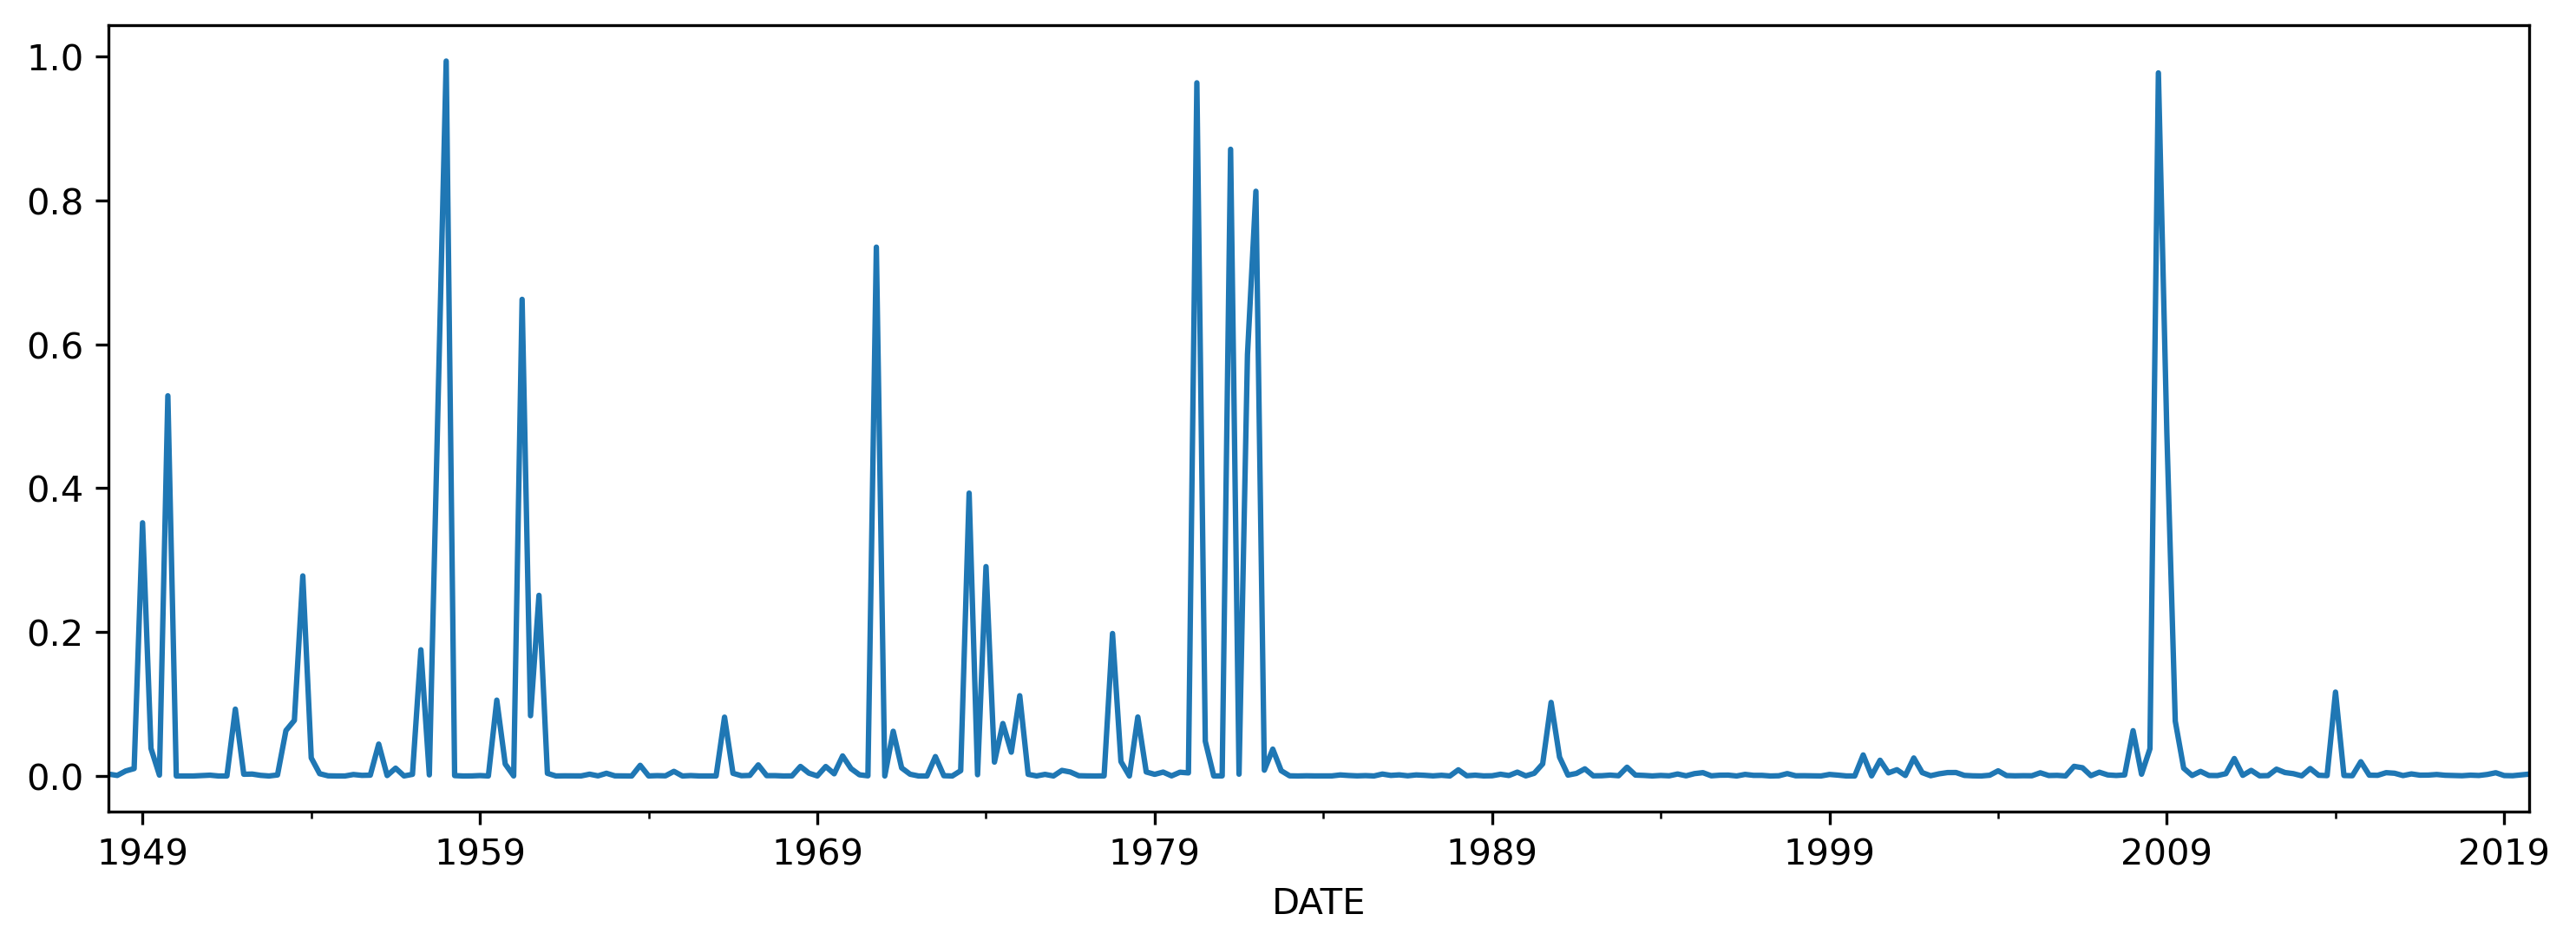

In [49]:
gdpgr_res2.filtered_marginal_probabilities[0].plot(figsize=(12,4))

In [50]:
# get NBER recessions data
usrec = pdr.get_data_fred('USREC', start=1947).squeeze()

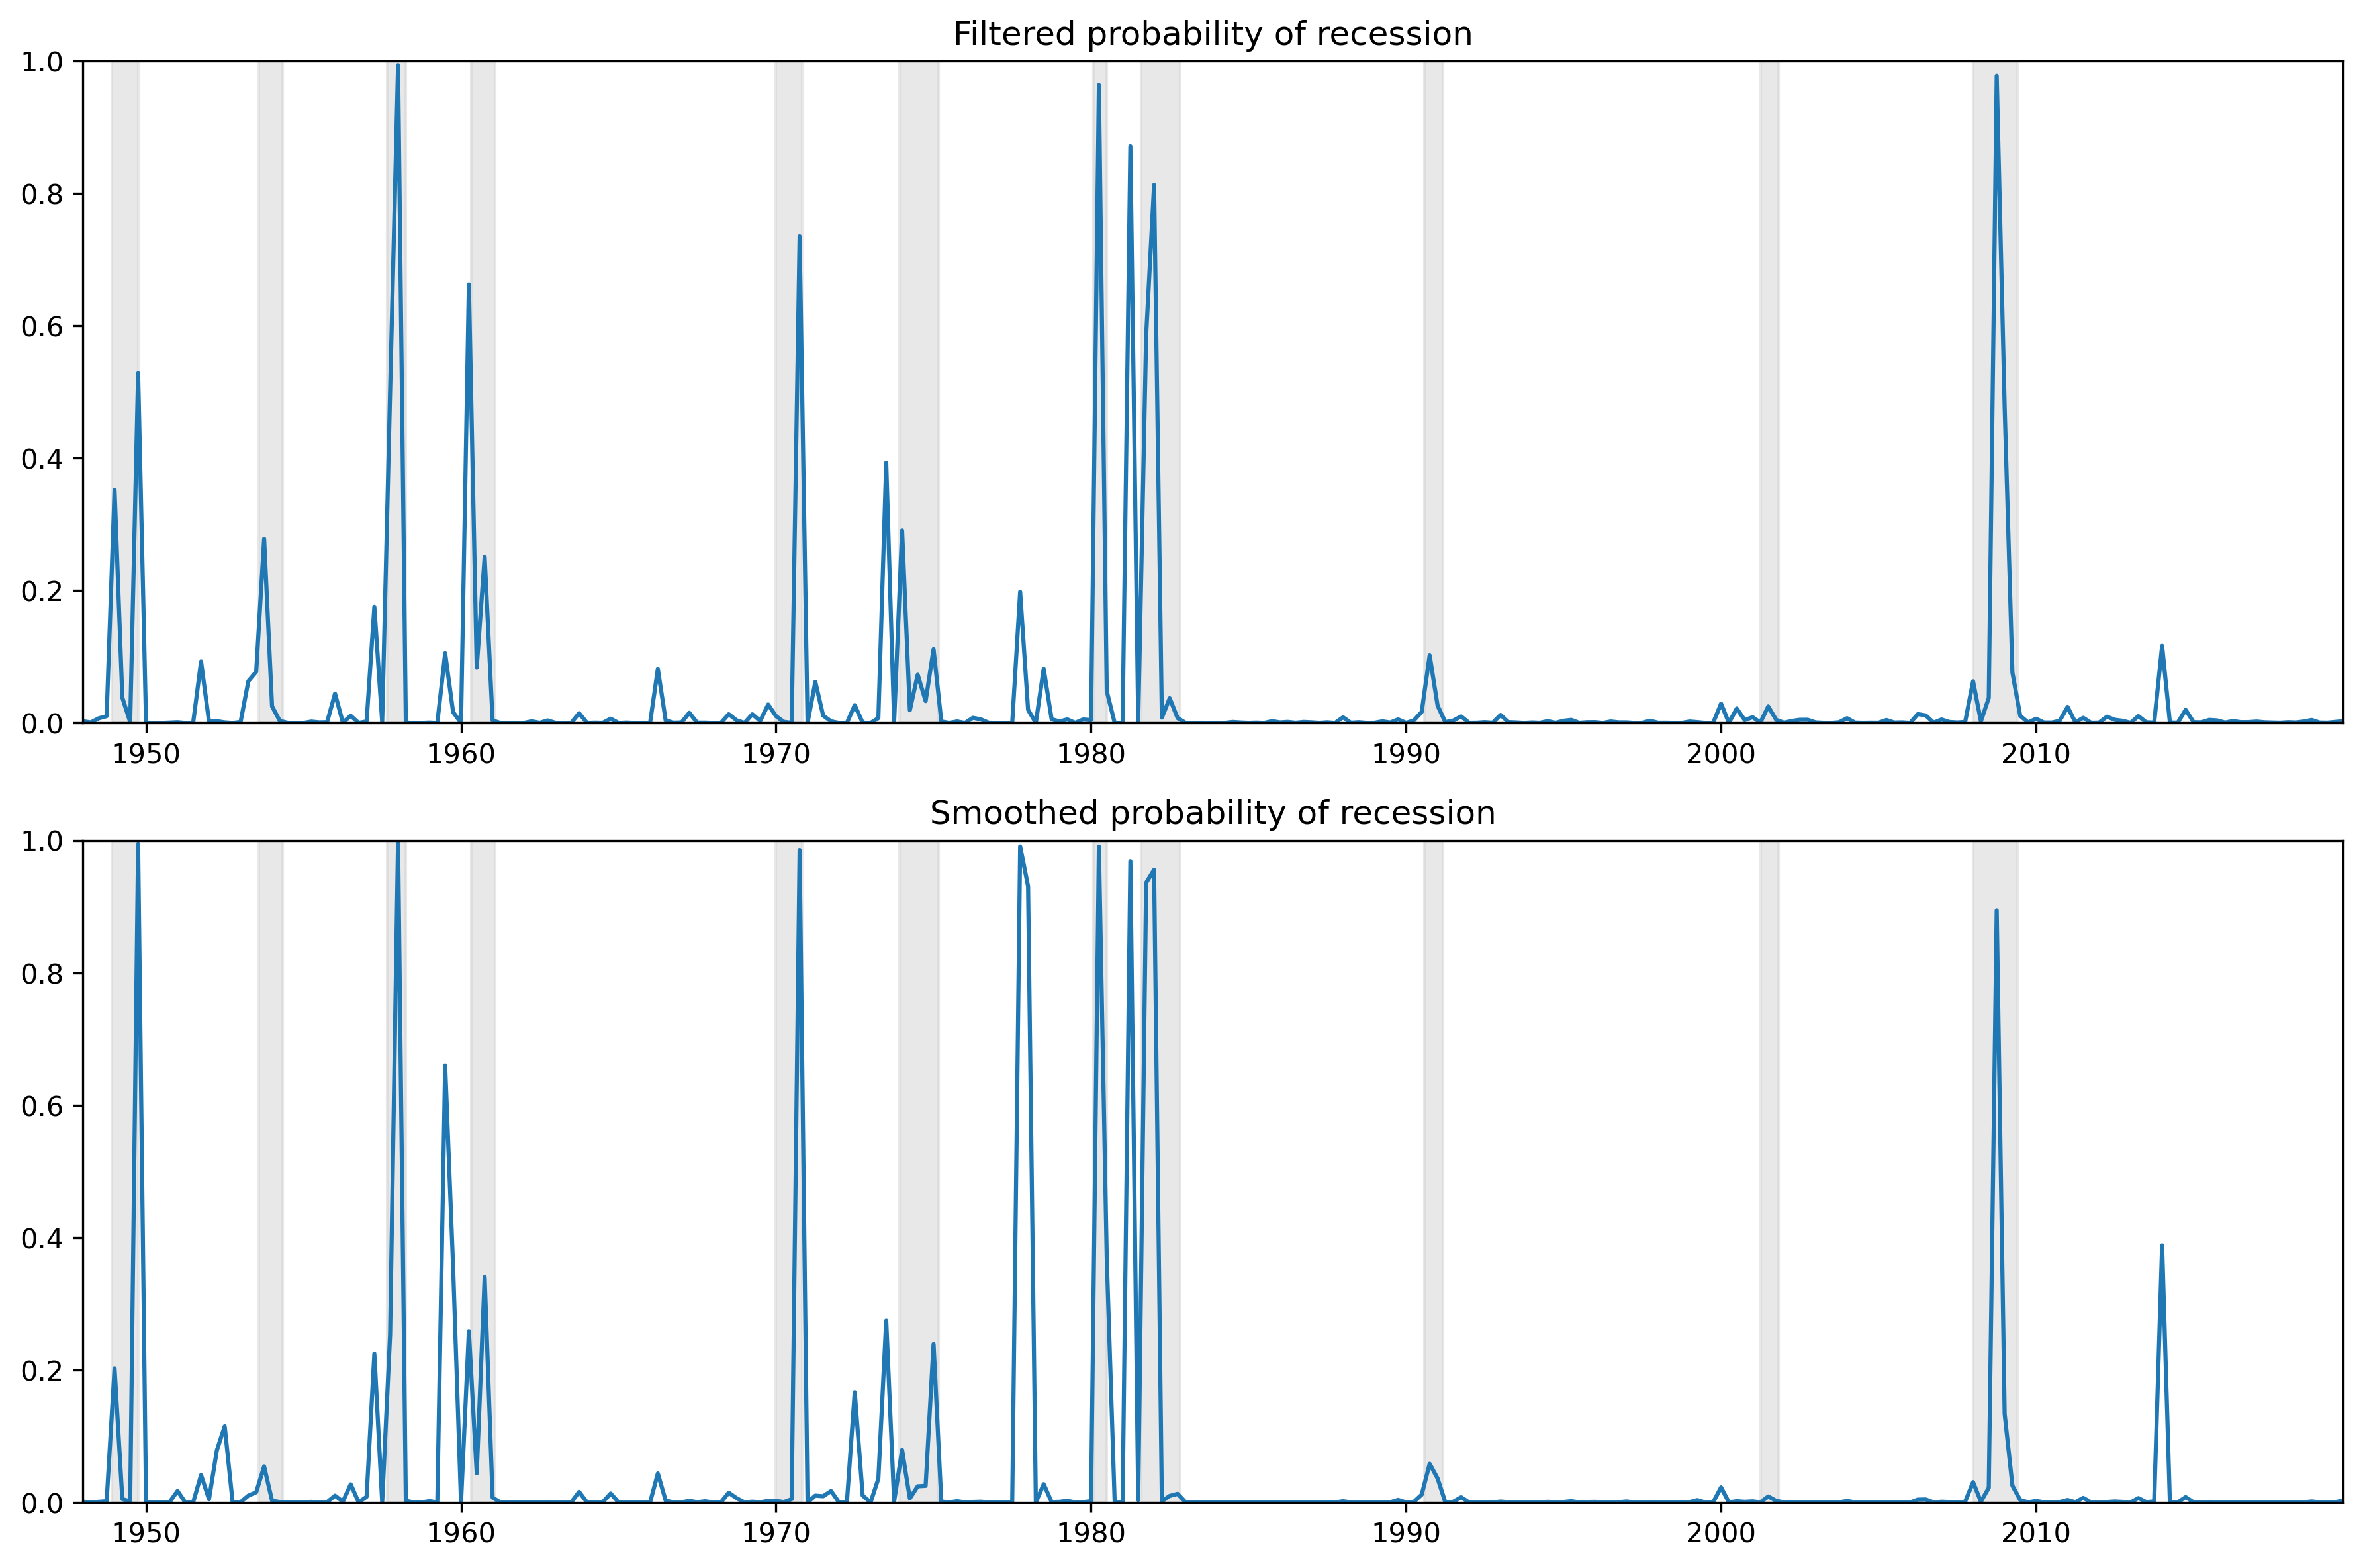

In [51]:
fig, axes = plt.subplots(2, figsize=(12,8))

ax = axes[0]
ax.plot(gdpgr_res2.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec.values,
                facecolor='lightgrey', edgecolor='lightgrey', alpha=0.5)
ax.set(title='Filtered probability of recession')

ax = axes[1]
ax.plot(gdpgr_res2.smoothed_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec.values,
                facecolor='lightgrey', edgecolor='lightgrey', alpha=0.5)
ax.set(title='Smoothed probability of recession')

for ax in axes:
    ax.set_ylim((0,1))
    ax.set_xlim(gdpgr.index[3], gdpgr.index[-1])

fig.tight_layout()

## The Great Moderation

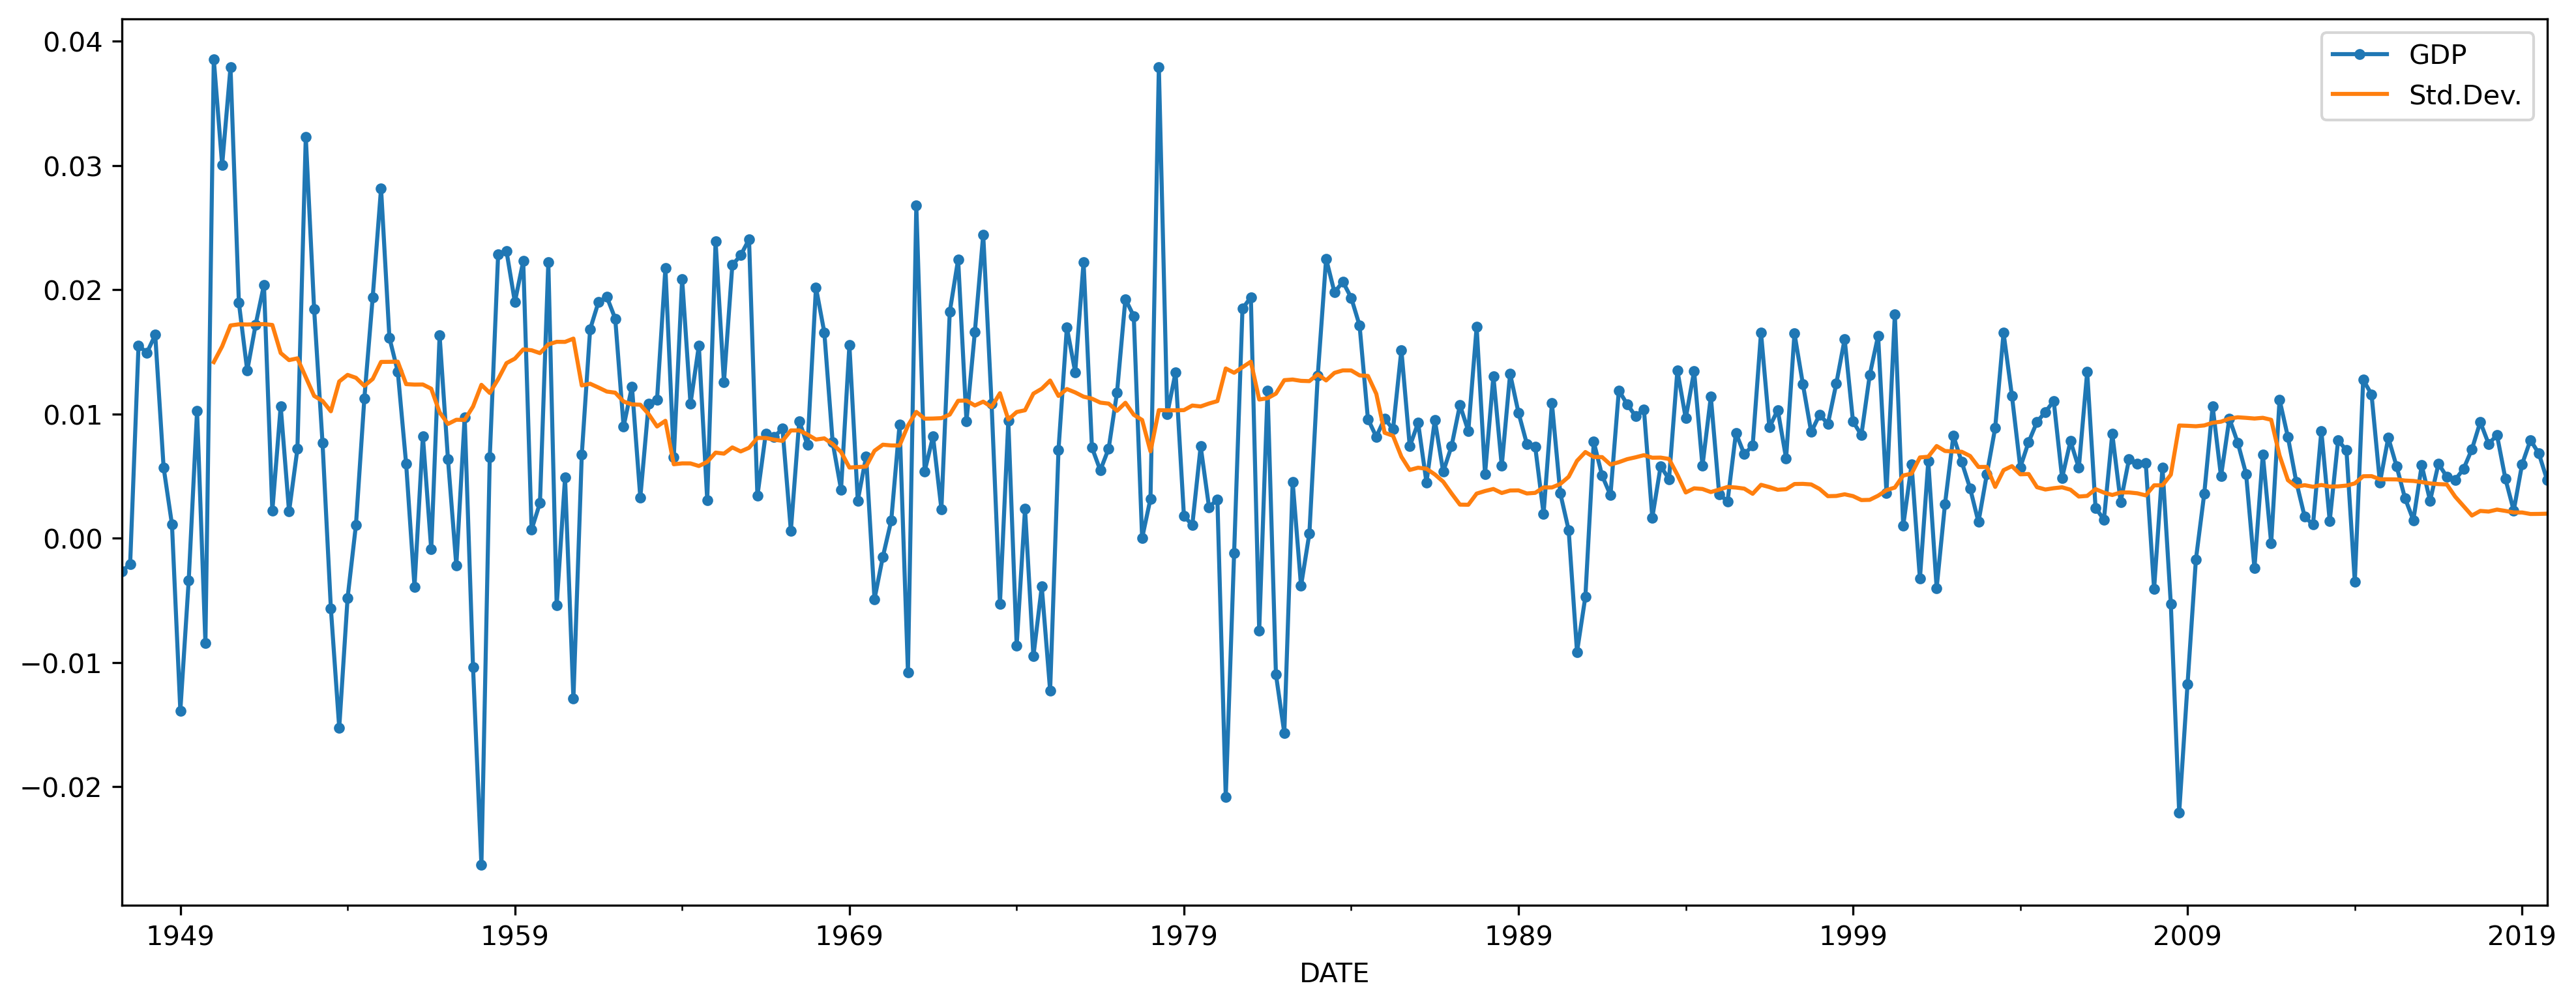

In [52]:
ax = gdpgr.loc[:'2019'].plot(figsize=(16,6), marker='.')

gdpgr.rolling(4*3).std().plot(ax=ax)

ax.legend(['GDP', 'Std.Dev.'])

The volatility in the series after 1985 is about half of what it is before that.

In [53]:
gdpgr[:'1985'].std()

GDPC1    0.011468
dtype: float64

In [54]:
gdpgr['1985':].std()

GDPC1    0.005604
dtype: float64

This decline in the volatility of GDP growth is known as the [Great Moderation](https://en.wikipedia.org/wiki/Great_Moderation).

We can estimate a Markov Switching Model where the autoregressive structure changes depending on which state we are in.

In [55]:
mod_gdpgr2 = MarkovAutoregression(gdpgr, k_regimes=2, order=3,
                                  switching_ar=True, 
                                  switching_variance=True)
res_gdpgr2 = mod_gdpgr2.fit(disp=True)
print(res_gdpgr2.summary())

Optimization terminated successfully.
         Current function value: -3.486913
         Iterations: 66
         Function evaluations: 87
         Gradient evaluations: 87
                         Markov Switching Model Results                         
Dep. Variable:                    GDPC1   No. Observations:                  288
Model:             MarkovAutoregression   Log Likelihood                1004.231
Date:                  Mon, 04 Apr 2022   AIC                          -1984.462
Time:                          14:46:15   BIC                          -1940.506
Sample:                      04-01-1947   HQIC                         -1966.847
                           - 10-01-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

The main difference in the models is the huge difference in the estimate of the volatility parameters in each regime:

In [56]:
res_gdpgr2.params.loc['sigma2[0]'] / res_gdpgr2.params.loc['sigma2[1]']

6.159718612641327

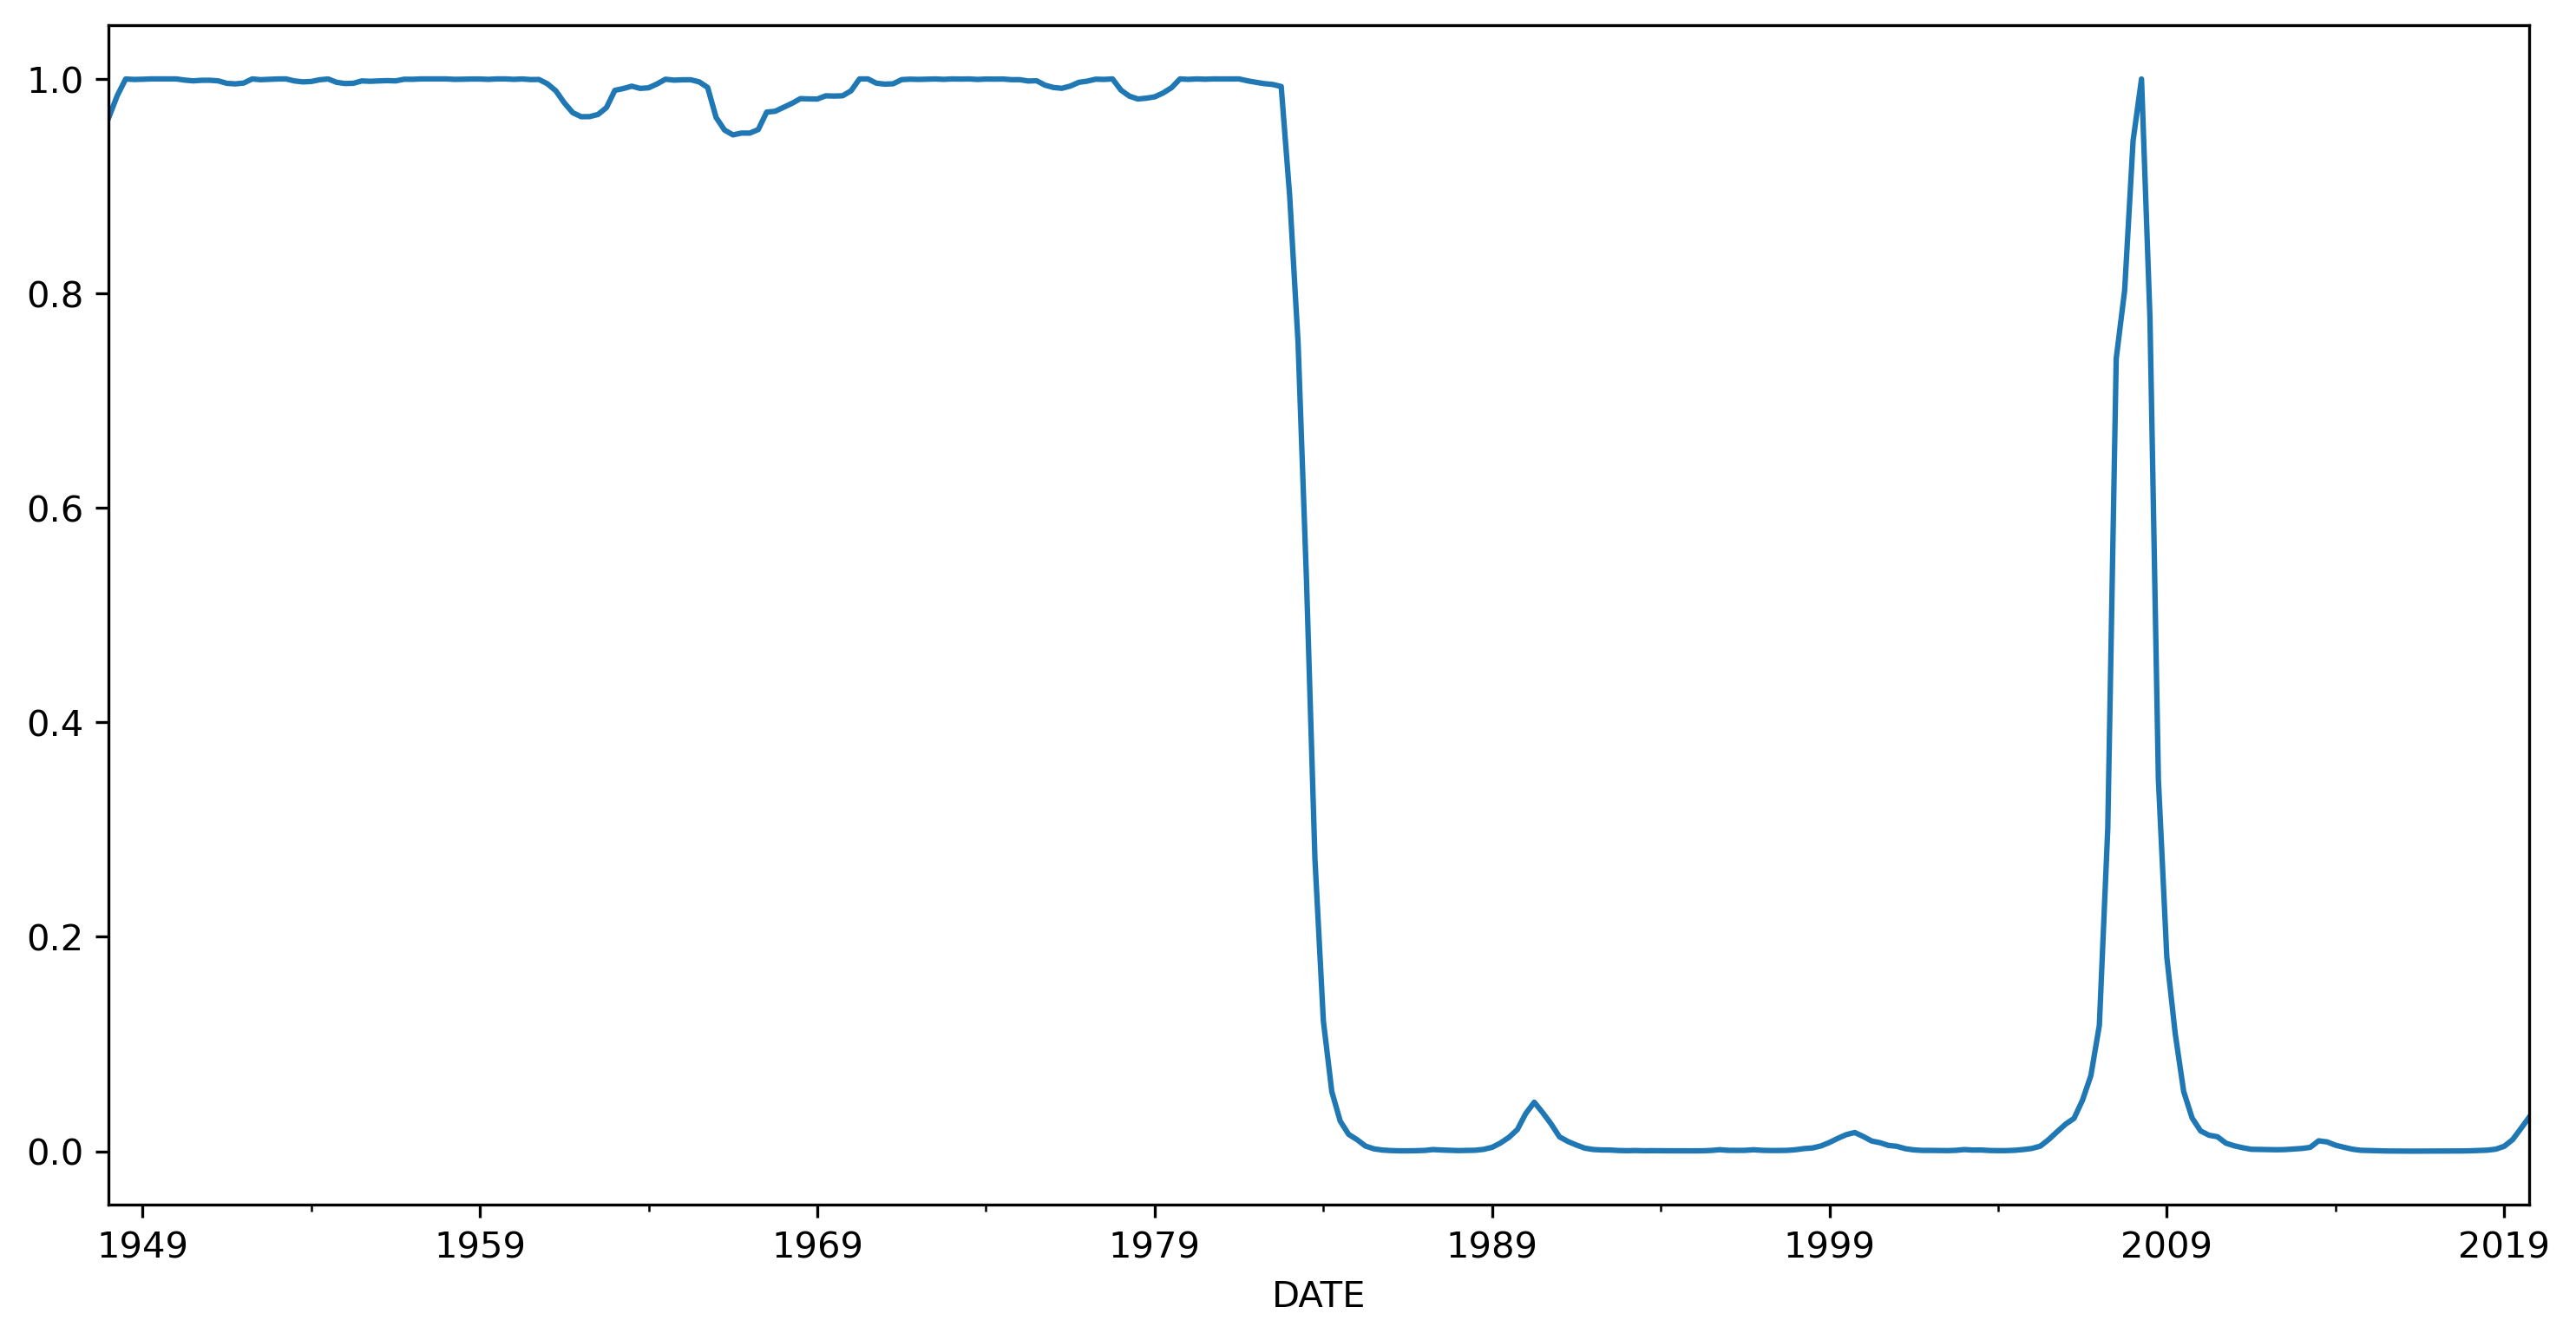

In [58]:
res_gdpgr2.smoothed_marginal_probabilities[0].plot();

In [60]:
import statsmodels.api as sm

from statsmodels.tsa import stattools as st

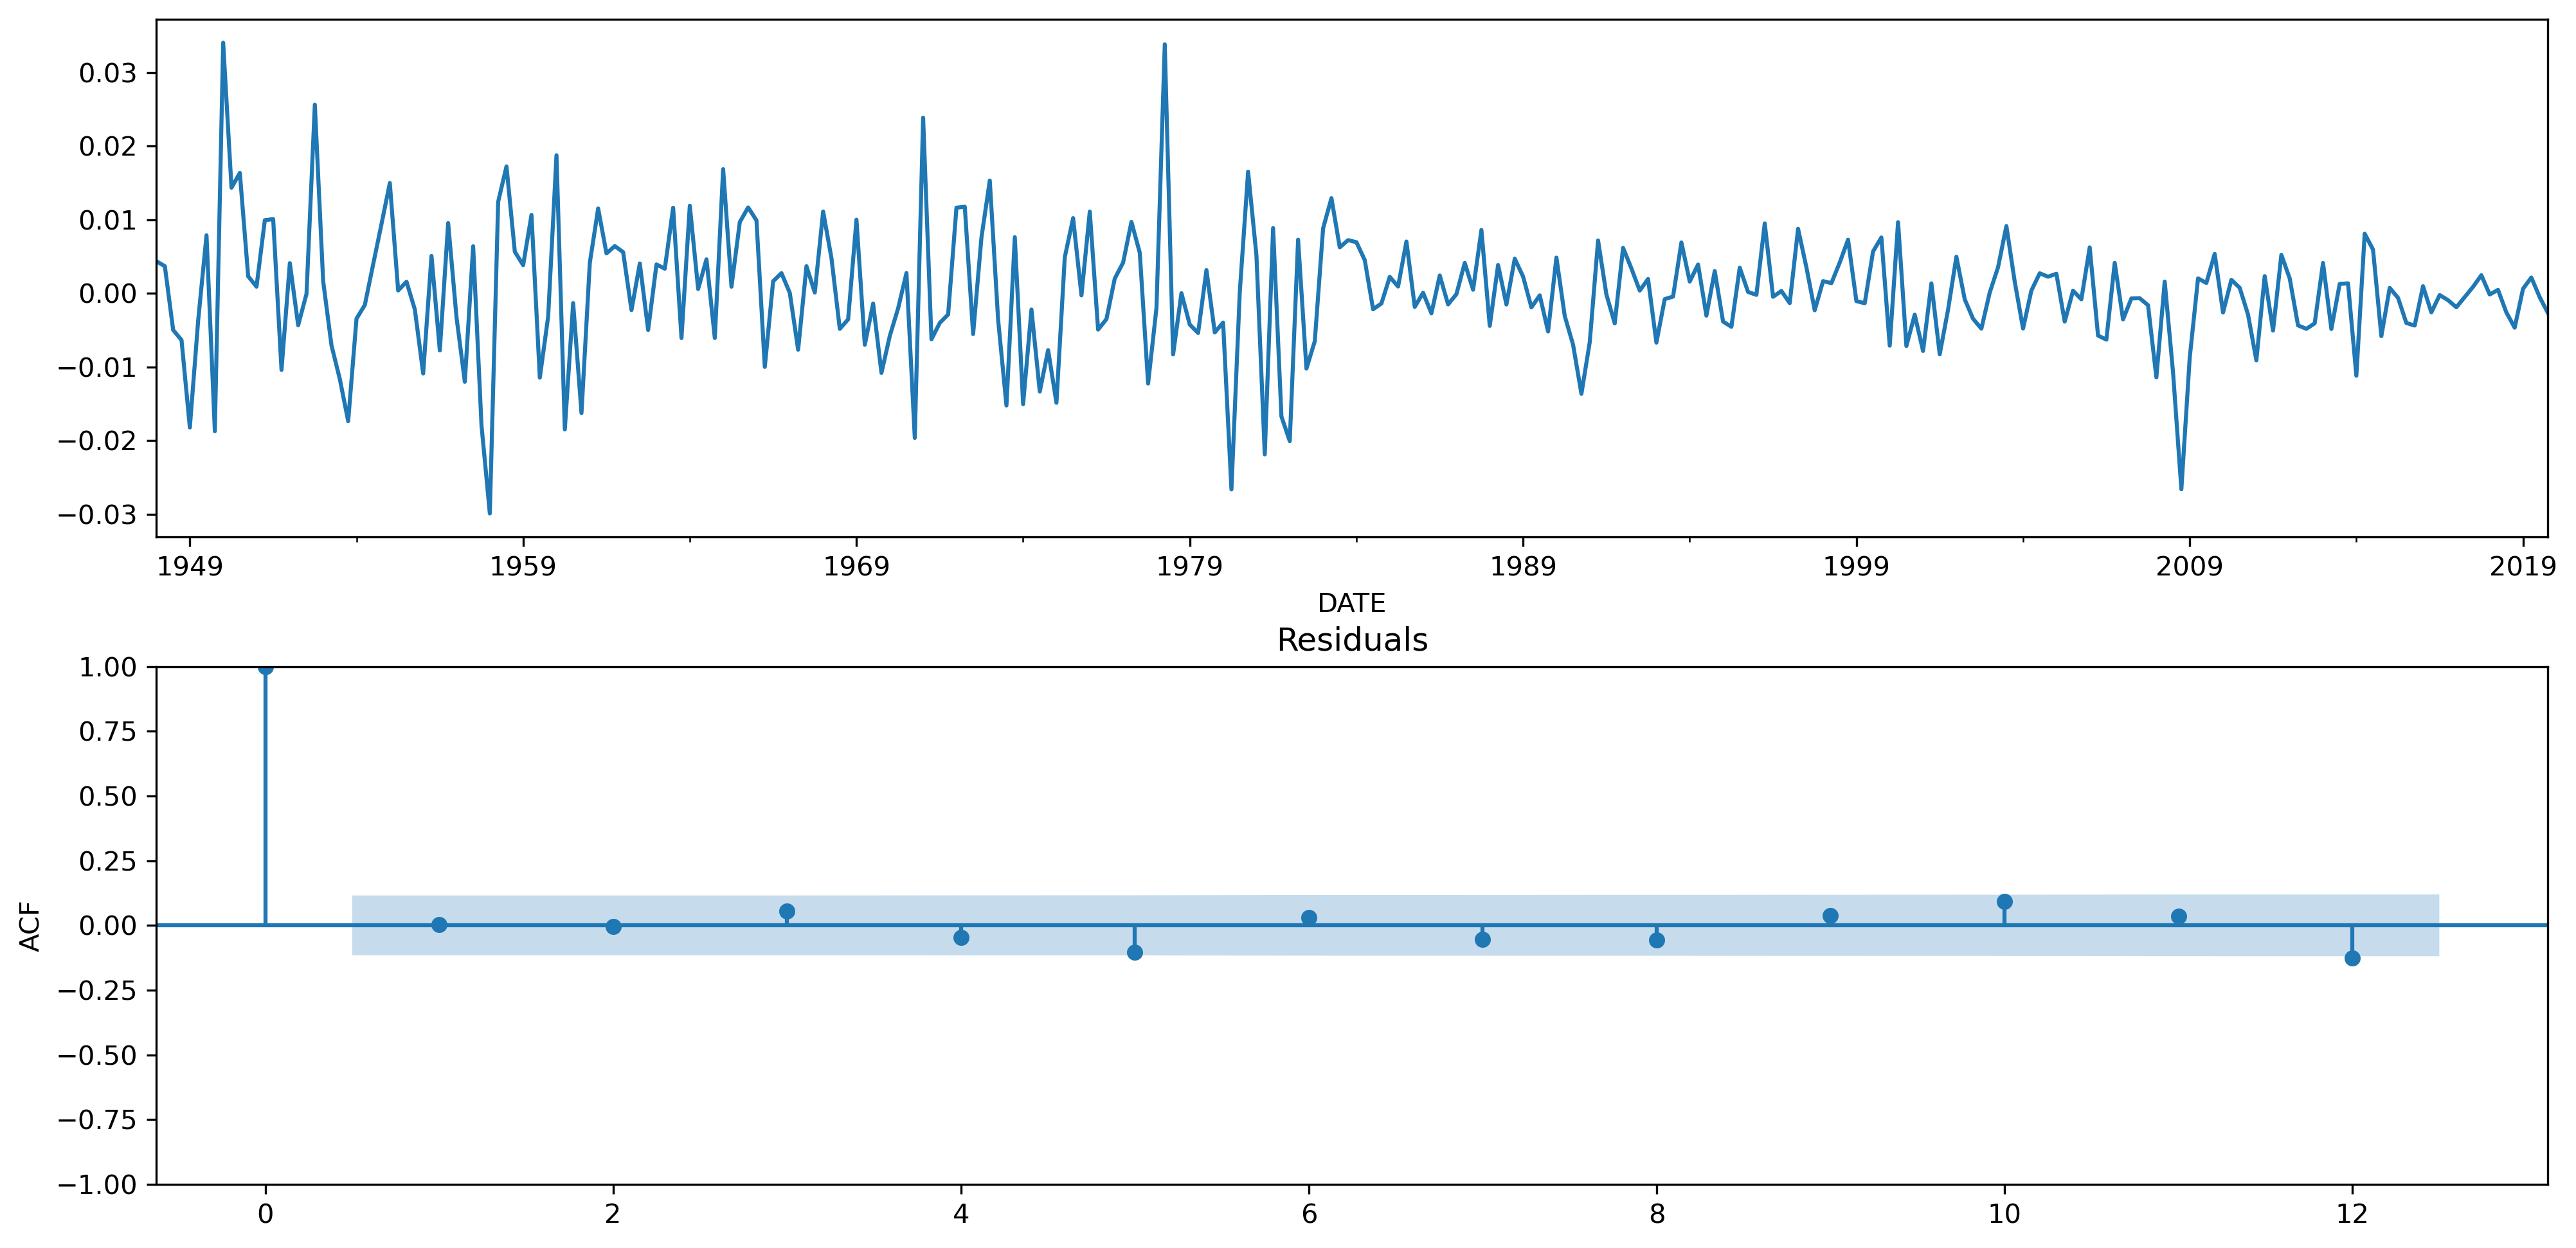

In [61]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
plt.subplots_adjust(hspace=0.25)

res_gdpgr2.resid.plot(ax=ax1)

fig = sm.graphics.tsa.plot_acf(res_gdpgr2.resid.values, lags=12, ax=ax2)
ax2.set_title('Residuals')
ax2.set_ylabel('ACF')

plt.show()

In [62]:
acf, qstats, pvals = st.acf(res_gdpgr2.resid, nlags=12, qstat=True)

In [63]:
pvals

array([0.95379976, 0.99555186, 0.83071072, 0.82418322, 0.45177622,
       0.54606175, 0.55594421, 0.5580098 , 0.61572801, 0.4633059 ,
       0.51778368, 0.23883035])